# Dashboard
* This notebook contains visualiations that could be incorporated into the final dashboard
* "Could your grandmother understand these visualizations?"

In [1]:
import ast
import datetime
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import regex as re
import seaborn as sns

from dateutil.relativedelta import relativedelta
from gensim.models.nmf import Nmf
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from scipy.stats import chi2_contingency, mannwhitneyu

## 0. Import and preprocess

In [2]:
# Placeholder for when we have the main data: Import and join docket and court summary csv files
#docketdf = pd.read_csv("parsed_dockets_2020.csv", index_col=0)
#courtdf = pd.read_csv("parsed_court_summaries_2020.csv", index_col=0)
#df = docketdf.merge(courtdf, on='docket_no', how='left')
#df.drop(columns = ['docket_no'], inplace = True)

In [3]:
df = pd.read_csv("parsed1.csv", index_col = 0)
df.drop(columns = ['docket_no'], inplace = True)

In [4]:
# Note: will need to change _dt to _date for column headings in new data

# convert string to datetime
#df["offense_date"] = pd.to_datetime(df["offense_date"])
df["arrest_dt"] = pd.to_datetime(df["arrest_dt"])
df["dob"] = pd.to_datetime(df["dob"])
df["bail_date"] = pd.to_datetime(df["bail_date"])
df["prelim_hearing_dt"] = pd.to_datetime(df["prelim_hearing_dt"])
df["prelim_hearing_time"] = pd.to_datetime(df["prelim_hearing_time"])

# age column
#df['age'] = df['dob'].apply(lambda x: 2020-x.year)
df['age'] = df['arrest_dt'] - df['dob']
df['age'] = df['age'].apply(lambda x: np.floor(x.days/365.2425))

# public defender column: 1 if public defender, 0 if private defender
df["public_defender"] = df["attorney"].apply(lambda x: 1 if x =='Defender Association of  Philadelphia' else 0)

# convert type of "offenses" and "parsed_offenses" from string representation of list to list
df["offenses"] = df["offenses"].apply(lambda x: ast.literal_eval(x))
df["parsed_offenses"] = df["parsed_offenses"].apply(lambda x: ast.literal_eval(x))

# zipcode: remove everything after hyphen
df["zipcode_clean"] = df["zip"].apply(lambda x: re.sub('-.*$','',x) if type(x) == str else x)

# Create column indicating whether zipcode is in philadelphia or not
philly_zipcode = list(range(19102, 19155))
philly_zipcode = [str(item) for item in philly_zipcode]
df['philly_zipcode'] = df['zipcode_clean'].apply(lambda x: 1 if x in philly_zipcode else 0)

In [5]:
# remove arrests that occurred between 5/31 - 6/3
df = df[(df['arrest_dt'] < np.datetime64('2020-05-31')) | (df['arrest_dt'] > np.datetime64('2020-06-03'))]

In [6]:
df.head()

,offenses,offense_date,arrest_dt,case_status,arresting_officer,attorney,dob,zip,bail_set_by,bail_amount,bail_paid,bail_date,bail_type,prelim_hearing_dt,prelim_hearing_time,parsed_offenses,age,public_defender,zipcode_clean,philly_zipcode
0,"[Rape Forcible Compulsion, Rape Forcible Compu...",5/28/20,2020-07-27,Active,"Bengochea, William",Defender Association of Philadelphia,1993-05-19,19123,"Bernard, Francis X.",300000,0,2020-07-28,Monetary,2020-07-28,2020-12-03 04:49:00,"[False Imprisonment, Indec Asslt-W/O Cons Of O...",27.0,1,19123,1
1,[Aggravated Assault - Attempts to cause SBI or...,5/4/20,2020-05-04,Active,"Soares, Baldomiro J. Jr.",Defender Association of Philadelphia,1997-05-05,19121,E-Filing Judge,50000,5000,2020-05-05,Monetary,2020-05-04,2020-12-03 17:33:00,[Aggravated Assault - Attempts to cause SBI or...,22.0,1,19121,1
2,"[Simple Assault, Simple Assault, Recklessly En...",2/2/20,2020-02-12,Active,"Jones, James",Defender Association of Philadelphia,1986-11-15,19124,"Stack, Patrick",7500,750,2020-02-13,Monetary,2020-02-13,2020-12-03 08:22:00,"[Recklessly Endangering Another Person, Simple...",33.0,1,19124,1
3,"[Contraband/Controlled Substance, Contraband/C...",2/10/20,2020-02-21,Active,"Balmer, James M.",Defender Association of Philadelphia,1980-12-13,19135,"Bernard, Francis X.",5000,0,2020-02-21,Unsecured,2020-02-21,2020-12-03 20:34:00,"[Contraband/Controlled Substance, Int Poss Con...",39.0,1,19135,1
4,"[Manufacture, Delivery, or Possession With Int...",3/13/20,2020-03-14,Active,"Sima, Raymond",Richard T. Brown Jr.,1997-11-05,19144,"Stack, Patrick",0,0,2020-03-14,ROR,2020-03-14,2020-12-03 08:40:00,"[Conspiracy, Int Poss Contr Subst By Per Not R...",22.0,0,19144,1


## 1. Aggregate bail information for the year 2020

Total number of cases analyzed (excluding 5/31 - 6/3): 12,772
Monetary       5337
ROR            3752
Unsecured      3323
Nonmonetary     156
Nominal           1
Name: bail_type, dtype: int64
-> Monetary bail set in 41.8% of cases
Total bail set: $657,399,598
Total bail paid: $10,730,725


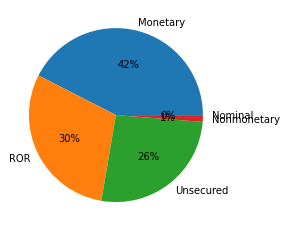

In [7]:
# Total cases, distribution of bail set
totalCases = len(df.index)
print("Total number of cases analyzed (excluding 5/31 - 6/3): {0:,}".format(totalCases))

# Bail type distribution
df_bail = df['bail_type'].value_counts()
print(df_bail)
bailTypes = df_bail.keys().tolist()
bailTypeCounts = df_bail.values

plt.pie(bailTypeCounts, labels=bailTypes, autopct='%1.0f%%')

# Total amount of bail set
df_monetary = df[df['bail_type'] == "Monetary"]
totalBailSet = df['bail_amount'].sum()
totalBailPaid = df['bail_paid'].sum()
print("-> Monetary bail set in {0:.1f}% of cases".format(100*df_bail["Monetary"]/totalCases))
print("\nTotal bail set: ${0:,}".format(totalBailSet))
print("Total bail paid: ${0:,}".format(totalBailPaid))

## 2. Visualizations on magistrate information

### 2.1 Select magistrates to include in the analysis  
* Out of 88 magistrates in data, select magistrates to analyze

In [8]:
print('Total number of magistrates: ', len(df['bail_set_by'].value_counts()))

Total number of magistrates:  88


<b> Total number of cases handled by each magistrate </b>

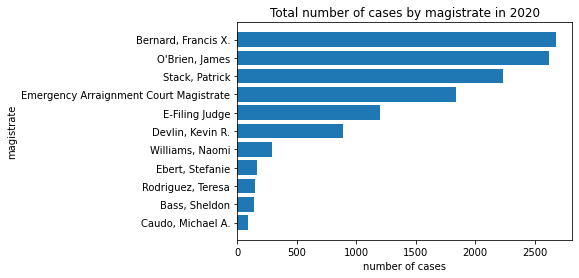

In [9]:
n_magistrates = 11
plt.barh(df['bail_set_by'].value_counts()[:n_magistrates].keys()[::-1], df['bail_set_by'].value_counts()[:n_magistrates].values[::-1])
plt.xlabel('number of cases')
plt.ylabel('magistrate')
plt.title('Total number of cases by magistrate in 2020')
plt.show()

In [10]:
df_magistrate = pd.crosstab(index = df['bail_set_by'], columns =df['bail_type'])
# note: total here excludes any entries with 'bail_type' == NaN
df_magistrate['Total'] = df_magistrate.sum(axis = 1)
df_magistrate.sort_values(by = ['Total'], ascending = False, inplace = True)
df_magistrate.head(11)

bail_type,Monetary,Nominal,Nonmonetary,ROR,Unsecured,Total
bail_set_by,,,,,,
"Bernard, Francis X.",1229,0,46,541,804,2620
"O'Brien, James",1188,0,52,573,778,2591
"Stack, Patrick",906,1,2,939,360,2208
Emergency Arraignment Court Magistrate,641,0,45,746,384,1816
E-Filing Judge,409,0,1,303,475,1188
"Devlin, Kevin R.",389,0,9,348,135,881
"Williams, Naomi",151,0,0,47,80,278
"Ebert, Stefanie",78,0,0,51,38,167
"Bass, Sheldon",42,0,0,60,43,145


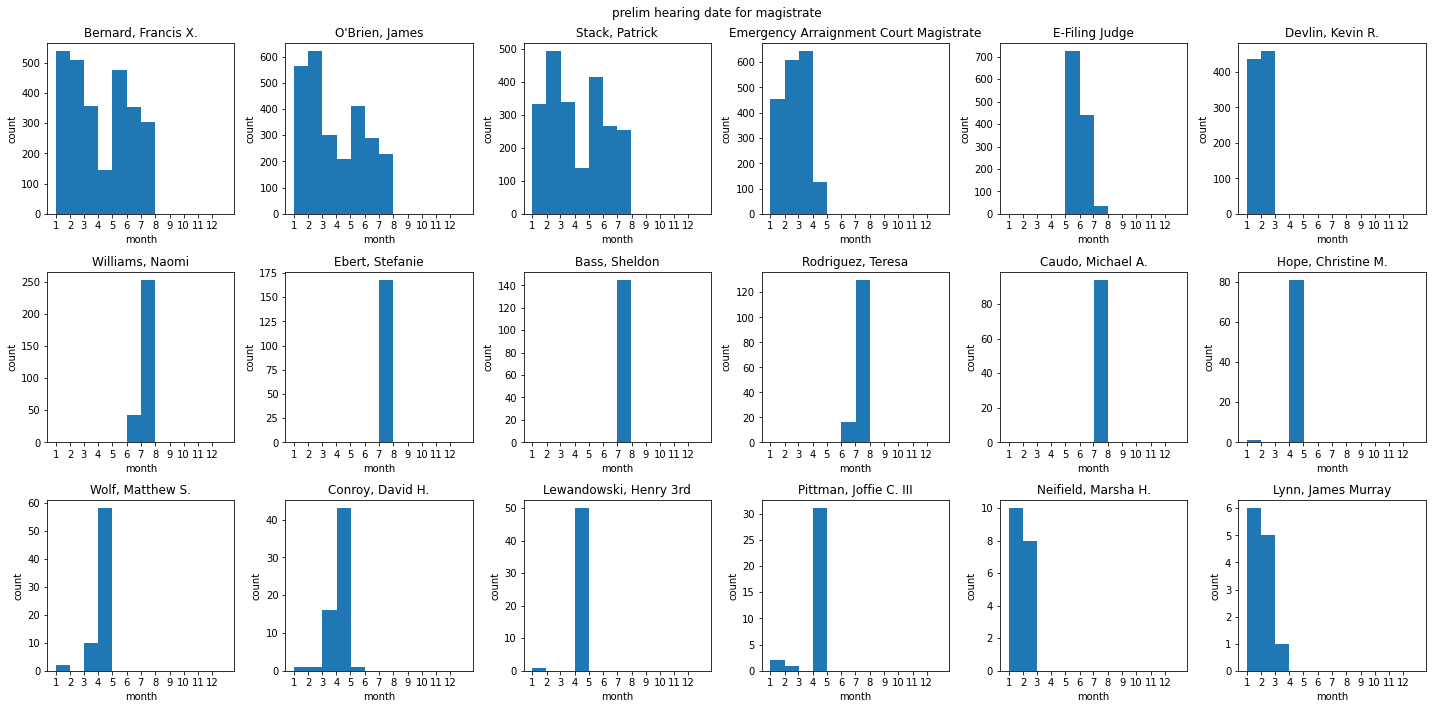

In [11]:
# prelim hearing date of each magistrate that were involved in more than 10 cases
magistrates = df_magistrate[df_magistrate['Total'] > 10].index

# get date ranges
start_date = datetime.date(2020, 1, 1)
end_date = datetime.date(2020, 12, 31)
delta = relativedelta(months = 1)
date_range = []

while start_date <= end_date:
    date_range.append(start_date)
    start_date += delta

# plot
fig, ax = plt.subplots(nrows = 3, ncols = 6, figsize = (20, 10))
plt.rcParams['font.size'] = 10
fig.suptitle('prelim hearing date for magistrate')
for idx, name in enumerate(magistrates):
    row = idx // 6
    col = idx % 6
    ax[row][col].hist(df[df['bail_set_by'] == name].prelim_hearing_dt, bins = 12, range = (datetime.date(2020,1,1), datetime.date(2020, 12 ,31)))
    ax[row][col].set_title(name)

for sub in ax.flat:
    sub.set_xticks(date_range)
    sub.set_xticklabels([item.month for item in date_range])
    sub.set_xlabel('month')
    sub.set_ylabel('count')
plt.tight_layout()
plt.show()

* Note: we only have data upto July 31.  
* 'Emergency Arraignment Court Magistrate' and 'E-Filing Judge' are probably the same entity -> 'E-filing Judge'
* Devlin stopped after February, but we'll include him in the list of magistrates since he was involved in many cases
* A few people started in July (Williams, Ebert, Bass, Rodriguez, Caudo). They may be new magistrates, so keep them in the list

In [12]:
# Correct 'Emergency Arraignment Court Magistrate' to 'E-Filing Judge'
df['bail_set_by'] = df['bail_set_by'].apply(lambda x: 'E-Filing Judge' if x == 'Emergency Arraignment Court Magistrate' else x)

In [13]:
# selected magistrates 
magistrates = ['Bernard, Francis X.', "O'Brien, James", 'Stack, Patrick', 'E-Filing Judge', 'Devlin, Kevin R.', 'Williams, Naomi','Ebert, Stefanie','Bass, Sheldon', 'Rodriguez, Teresa', 'Caudo, Michael A.']
print("Selected magistrates: ")
for name in magistrates:
    print(name)

Selected magistrates: 
Bernard, Francis X.
O'Brien, James
Stack, Patrick
E-Filing Judge
Devlin, Kevin R.
Williams, Naomi
Ebert, Stefanie
Bass, Sheldon
Rodriguez, Teresa
Caudo, Michael A.


In [14]:
core_magistrates = ['Bernard, Francis X.', "O'Brien, James", 'Stack, Patrick', 'E-Filing Judge']

### 2.2 Are bail type and magistrate correlated?

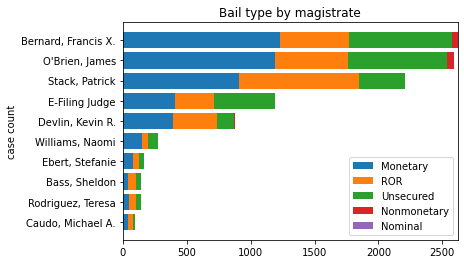

In [15]:
monetary = df_magistrate['Monetary'][magistrates].values[::-1]
ROR = df_magistrate['ROR'][magistrates].values[::-1]
Unsecured = df_magistrate['Unsecured'][magistrates].values[::-1]
Nonmonetary = df_magistrate['Nonmonetary'][magistrates].values[::-1]
Nominal = df_magistrate['Nominal'][magistrates].values[::-1]
ind = range(len(magistrates))

plt.barh(ind, monetary)
plt.barh(ind, ROR, left = monetary)
plt.barh(ind, Unsecured, left = monetary + ROR)
plt.barh(ind, Nonmonetary, left = monetary + ROR + Unsecured)
plt.barh(ind, Nominal, left = monetary + ROR + Unsecured + Nonmonetary)
plt.legend(labels = ['Monetary', 'ROR', 'Unsecured', 'Nonmonetary', 'Nominal'])
plt.ylabel('magistrate')
plt.yticks(ind, magistrates[::-1])
plt.ylabel('case count')
plt.title('Bail type by magistrate')
plt.show()

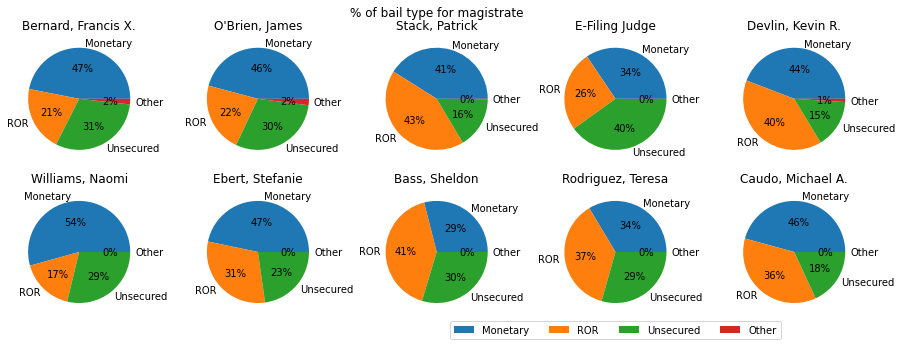

In [16]:
# since there are only a few nominal and non-monetary, combine them into 'other'
df_magistrate['Other'] = df_magistrate['Nominal'] + df_magistrate['Nonmonetary']

bail_types = ['Monetary','ROR', 'Unsecured', 'Other']
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 5))
plt.rcParams['font.size'] = 10
fig.suptitle('% of bail type for magistrate')
for idx, name in enumerate(magistrates):
    row = idx // 5
    col = idx % 5
    ax[row][col].pie(df_magistrate.loc[name, bail_types], labels = bail_types, autopct='%1.0f%%')
    ax[row][col].set_title(name)

# common legend
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=4)

plt.show()

Q: Are bail type and magistrate related?  

In [17]:
# remove 'nominal' since we don't have enough cases 
df_chi = df_magistrate.drop(columns = ['Nominal', 'Nonmonetary', 'Total'])

# chi-squared test
chi2, p, dof, ex = chi2_contingency(df_chi.loc[magistrates])
print('p-value of chi-square test: ', p)

p-value of chi-square test:  1.4295736152377098e-125


* chi-square test tells us that **bail type and magistrate are related.**  

Q: Are bail type (monetary vs others) and magistrate related?

In [18]:
# Keep only "monetary"
df_chi = df_magistrate[['Monetary', 'Total']]

# chi-squared test
chi2, p, dof, ex = chi2_contingency(df_chi.loc[magistrates])
print('p-value of chi-square test: ', p)


p-value of chi-square test:  1.1133559468898208e-05


* chi-square test tells us that **bail type and magistrate are related.**  

### 2.3 For monetary bail, does bail amount vary by magistrate? 

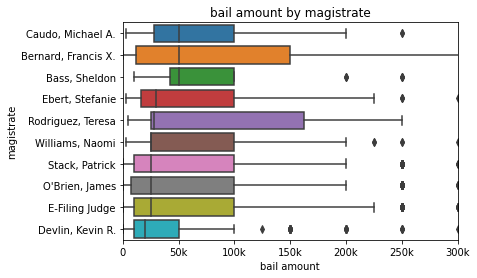

In [19]:
df['magistrate'] = df['bail_set_by'].apply(lambda x: 1 if x in magistrates else 0)
df_monetary = df[(df['bail_type'] == 'Monetary') & (df['magistrate'] == 1)][['bail_set_by', 'bail_amount']]

# order by median amount
order = df_monetary.groupby(['bail_set_by']).bail_amount.median().sort_values(ascending = False).keys()

# plot
plt.rcParams['font.size'] = 10
sns.boxplot( y=df_monetary["bail_set_by"], x=df["bail_amount"], 
           order = order)
plt.xlim(0, 300000)
plt.xlabel('bail amount')
plt.xticks(ticks = range(0, 350000, 50000), labels = ['0','50k','100k','150k','200k','250k','300k'])
plt.ylabel('magistrate')
plt.title('bail amount by magistrate')
plt.show()

Histogram for a particular magistrate

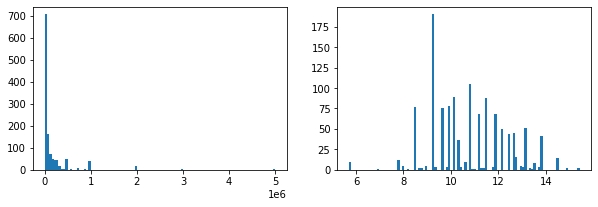

In [20]:
# ignore bail amount == 0
df_monetary = df_monetary[df_monetary['bail_amount']!= 0]

# apply log transform
df_monetary['log_bail_amount'] = df_monetary['bail_amount'].apply(lambda x: np.log(x))

fig, ax = plt.subplots(ncols = 2, figsize = (10, 3))
ax[0].hist(df_monetary[df_monetary["bail_set_by"] == 'Bernard, Francis X.'].bail_amount, bins =100)
ax[1].hist(df_monetary[df_monetary["bail_set_by"] == 'Bernard, Francis X.'].log_bail_amount, bins =100)
plt.show()

* log transform doesn't help in getting the distribution to look normal.
* Instead of doing a t-test, we'll use a non-parametric test: Mann-Whitney U-test

In [21]:
# create order of magistrates
# note: the index was manually decided to make the correlation matrix look nice.

magistrate_order = ['Caudo, Michael A.','Bernard, Francis X.','Bass, Sheldon','Williams, Naomi','Ebert, Stefanie','Rodriguez, Teresa', 
                    'E-Filing Judge' ,'Stack, Patrick',
                   "O'Brien, James", 'Devlin, Kevin R.']

magistrate_index = {}
for idx, person in enumerate(magistrate_order):
    magistrate_index[person] = idx

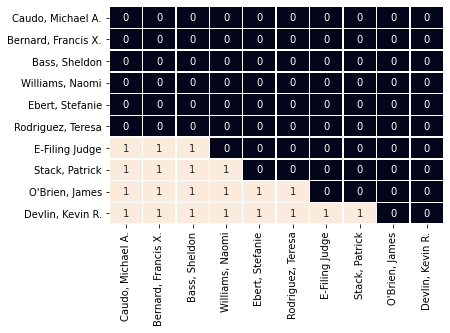

In [22]:
# matrix of differences
n_magistrates = len(magistrates)
diff_matrix = np.zeros((n_magistrates, n_magistrates))

for item in itertools.combinations(order, 2):
 
    # select two magistrates to compare
    data1 = df_monetary[df_monetary['bail_set_by'] == item[0]].bail_amount
    data2 = df_monetary[df_monetary['bail_set_by'] == item[1]].bail_amount

    # Mann-Whitney U test
    statistic, pvalue = mannwhitneyu(data1, data2, alternative = 'greater')
    
    # save p-values
    if pvalue < 0.005:
        idx0 = magistrate_index[item[0]]
        idx1 = magistrate_index[item[1]]
        
        #diff_matrix[idx0, idx1] = 1
        diff_matrix[idx1, idx0] = 1
        
# plot
g = sns.heatmap(diff_matrix, linewidths=.5, annot = True, cbar = False)
g.set_xticklabels(magistrate_order, rotation = 90)
g.set_yticklabels(magistrate_order, rotation = 0)
plt.show()

* Interpretation
    * If entry at particular row and column is white: Bail set by column-magistrate is likely to be higher than bail set by row-magistrate
    * If X: bail set by column magistrate, Y: bail set by row-magistrate, P(X>Y) > 0.5
    * ex) first column: Bail set by Caudo is likely to be higher than bail set by E-Filing Judge, Stack, O'Brien, and Devlin
* Among the core magistrates (O'Brien, Stack, Bernard, and E-Filing Judge)
    * Bail amount set by Bernard is likely to be higher than bail set by E-Filing Judge, Stack, and O'Brien.

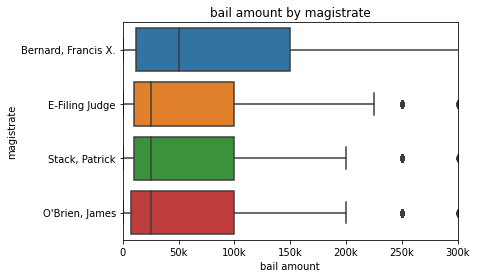

In [23]:
# image for the core magistrates
core_magistrates = ['Bernard, Francis X.', 'E-Filing Judge' ,'Stack, Patrick', "O'Brien, James"]
df['core_magistrate'] = df['bail_set_by'].apply(lambda x: 1 if x in core_magistrates else 0)
df_monetary = df[(df['bail_type'] == 'Monetary') & (df['magistrate'] == 1)][['bail_set_by', 'bail_amount']]

# Bail amount by groups
plt.rcParams['font.size'] = 10
sns.boxplot( y=df_monetary["bail_set_by"], x=df["bail_amount"], 
           order = core_magistrates)
plt.xlim(0, 300000)
plt.xlabel('bail amount')
plt.xticks(ticks = range(0, 350000, 50000), labels = ['0','50k','100k','150k','200k','250k','300k'])
plt.ylabel('magistrate')
plt.title('bail amount by magistrate')
plt.show()

In [24]:
# Maybe 4 histograms will be easier to see

### 2.4 Are preliminary hearing date and time related to magistrates?

This may be relevant, as offense severity may depend on hearing time 

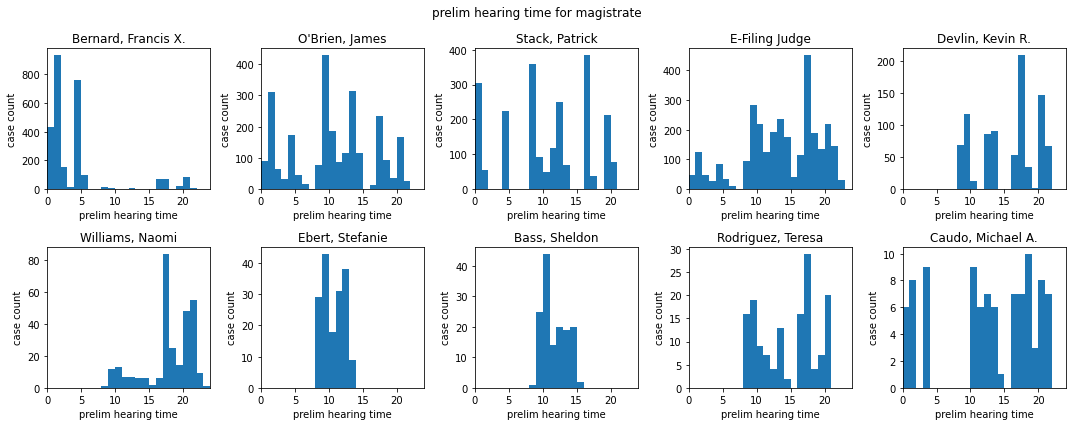

In [25]:
df['prelim_hearing_hour'] = df['prelim_hearing_time'].apply(lambda x: x.hour)
# prelim hearing time (hour) of each magistrate

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 6))
plt.rcParams['font.size'] = 10
fig.suptitle('prelim hearing time for magistrate')
for idx, name in enumerate(magistrates):
    row = idx // 5
    col = idx % 5 
    ax[row][col].hist(df[df['bail_set_by'] == name].prelim_hearing_hour, bins=24, range=(0,24))
    ax[row][col].set_title(name)

for sub in ax.flat:
    sub.set_xlim(0,24)
    sub.set_xlabel('prelim hearing time')
    sub.set_ylabel('case count')
plt.tight_layout()
plt.show()

### 2.5 Are specific magistrates more likely to handle specific types of offenses?

Use topic modeling to extract offense type (for now)
Options:
* TF-IDF
* LDA
* NMF


<b> Remove offenses with super long length </b>

In [26]:
# remove offenses with super long length
df['max_offense_length'] = df['parsed_offenses'].apply(lambda x: max([len(item) for item in x]))

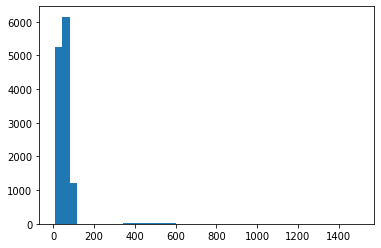

In [27]:
plt.hist(df['max_offense_length'], bins = 40)
plt.show()

In [28]:
# look at those with max offense length >= 200 
df_long = df[df['max_offense_length'] >= 200]

In [29]:
# remove offenses with long length
df['cleaned_offenses'] = df['parsed_offenses'].apply(lambda x: [item for item in x if len(item) < 200])

<b> topic modeling via NMF </b>

In [30]:
# prepare text (offenses)
corpus = df['cleaned_offenses'].apply(lambda x: ' '.join(x)).tolist()

# remove stop words
stopwords = ['for','a','of','the','and','to','in', 'or']

# corpus format: list of list
# lowercase
corpus = [[word for word in text.lower().split() if word not in stopwords] for text in corpus]

In [31]:
# create dictionary of worrds
dictionary = Dictionary(corpus)

In [32]:
# split to training and CV set 
n_documents = len(corpus)

total = list(range(n_documents))
random.shuffle(total)

train_size = int(n_documents * 0.7)
train_idx = total[:train_size]
cv_idx = total[train_size:]

# train document
train_doc = [corpus[idx] for idx in train_idx]
cv_doc = [corpus[idx] for idx in cv_idx]

# prepare corpus
train_corpus = [dictionary.doc2bow(text) for text in train_doc]
cv_corpus = [dictionary.doc2bow(text) for text in cv_doc]
total_corpus = [dictionary.doc2bow(text) for text in corpus]

print('number of training set: ', len(train_idx))
print('number of cv set: ', len(cv_idx))

number of training set:  8940
number of cv set:  3832


In [33]:
# compute coherence scores for NMF models of various topic numbers
topic_numbers = list(range(5,30))
scores = {}

for k in topic_numbers:
    # train NMF model
    nmf = Nmf(train_corpus, id2word = dictionary, num_topics = k)
    
    # compute coherence on cv
    cm = CoherenceModel(model=nmf, texts=cv_doc, window_size = 50, coherence='c_uci')
    coherence = cm.get_coherence() 
    scores[k] = coherence

/home/notchia/miniconda3/envs/pbfa/lib/python3.8/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)


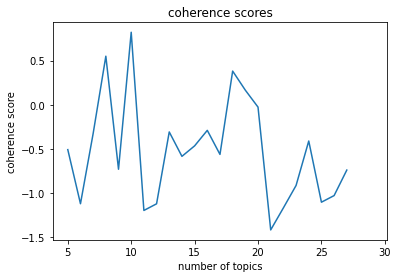

In [34]:
plt.plot(topic_numbers, [scores[item] for item in topic_numbers])
plt.xlabel('number of topics')
plt.ylabel('coherence score')
plt.title('coherence scores')
plt.show()

It seems like coherence score is maximized when number of topics is 15 
Q: Why is the coherence score not computed for some topic numbers?

In [35]:
# train NMF model
nmf = Nmf(total_corpus, id2word = dictionary, num_topics = 15)

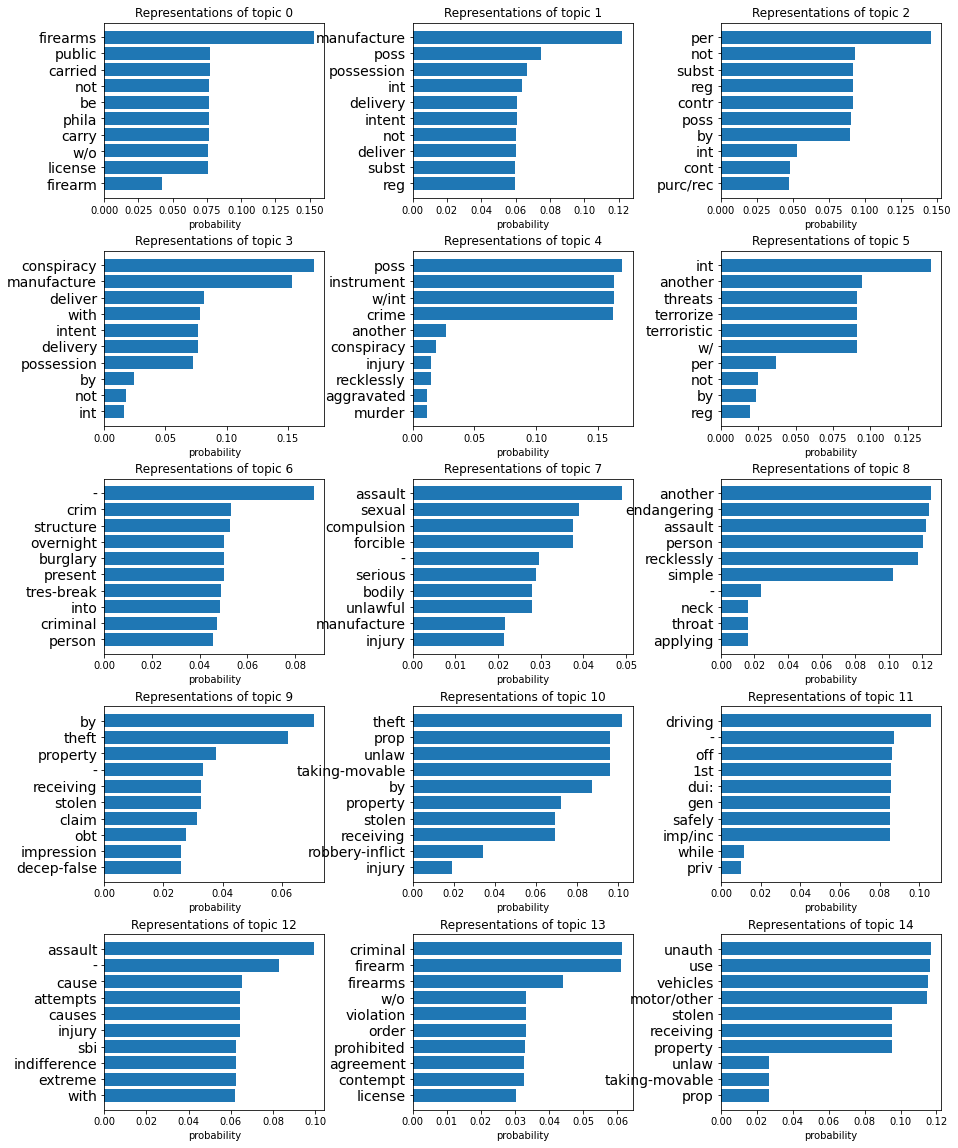

In [36]:
# Visualize topic representations for 4 (out of 15) topics
fig, ax = plt.subplots(nrows = 5, ncols = 3, figsize = (15, 20))

for i in range(15):
    row = i // 3
    col = i % 3
    
    topic_rep = nmf.show_topic(i)
    words = [item[0] for item in topic_rep][::-1]
    prob = [item[1] for item in topic_rep][::-1]
    
    ax[row][col].barh(words, prob)
    ax[row][col].tick_params(axis="y", labelsize=14)
    ax[row][col].set_xlabel('probability')
    ax[row][col].set_title('Representations of topic '+ str(i))
    
fig.subplots_adjust(wspace=0.4, hspace = 0.3)
plt.show()

In [37]:
# save NMF model
#nmf.save('offenses_nmf')

# to load
nmf = Nmf.load('offenses_nmf')

In [38]:
# for each offense, assign topic number 
topic_numbers = []

for case in total_corpus:
    topics = nmf[case]
    topic_num = [item[0] for item in topics]
    topic_prob = [item[1] for item in topics]
    topic_numbers.append(topic_num[topic_prob.index(max(topic_prob))])

In [39]:
# create column of offense type
df['topic_numbers'] = topic_numbers

# create dummy variables
#df = pd.concat([df, pd.get_dummies(df['topic_numbers'], prefix = 'offense_')], axis=1)

<b> Q: Are there correlations between offense type and magistrate? </b>

In [40]:
df_magistrate_offense = pd.crosstab(index = df['bail_set_by'], columns =df['topic_numbers'])
df_magistrate_offense['Total'] = df_magistrate_offense.sum(axis = 1)

In [41]:
df_magistrate_offense.loc[core_magistrates]

topic_numbers,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Total
bail_set_by,,,,,,,,,,,,,,,,
"Bernard, Francis X.",293,75,225,166,144,71,168,86,152,125,461,176,15,208,314,2679
E-Filing Judge,339,98,278,270,191,74,207,90,170,124,364,215,15,250,350,3035
"Stack, Patrick",299,65,198,192,112,58,128,81,100,76,335,155,15,163,258,2235
"O'Brien, James",317,81,234,215,138,75,175,78,114,135,377,151,20,250,263,2623


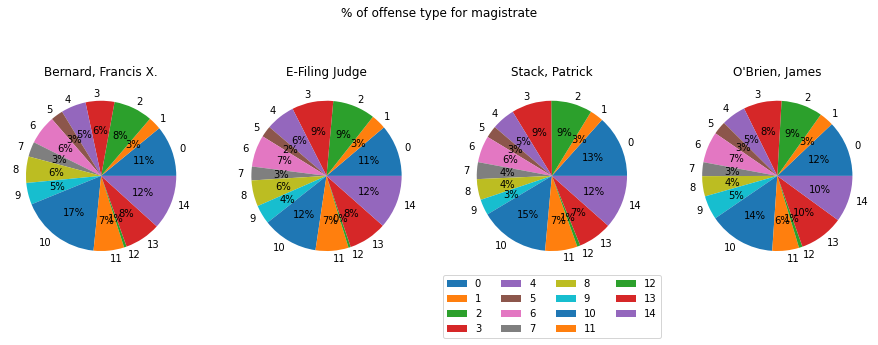

In [42]:
# visualize

topic_nums = list(range(15))

fig, ax = plt.subplots(ncols = 4, figsize = (15, 5))
plt.rcParams['font.size'] = 10
fig.suptitle('% of offense type for magistrate')
for idx, name in enumerate(core_magistrates):

    ax[idx].pie(df_magistrate_offense.loc[name, topic_nums], labels = topic_nums, autopct='%1.0f%%')
    ax[idx].set_title(name)

# common legend
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=4)

plt.show()

From what we see above, each magistrate seems to handle similar proportions of offense types

In [43]:
# test
df_chi = df_magistrate_offense.drop(columns = ['Total'])

# chi-squared test
chi2, p, dof, ex = chi2_contingency(df_chi.loc[core_magistrates])
print('p-value of chi-square test: ', p)

p-value of chi-square test:  1.7479275941159963e-06


From the above, it's kind of hard to tell why we get a significant result. we may need more specific tests

<b>To do</b>: Do chi-square test for each topic number as following: topic i vs non-topic i

In [44]:
# example for topic 1
df_chi = df_magistrate_offense.loc[core_magistrates]
df_chi['not_1'] = df_chi['Total'] - df_chi[1]

# chi-squared test
chi2, p, dof, ex = chi2_contingency(df_chi[[1, 'not_1']])
print('p-value of chi-square test: ', p)

p-value of chi-square test:  0.7929009255461423


### 2.6 Predict bail type and bail amount. Find the important factors

## 3. Which neighborhoods are heavily impacted by bail?

The following visualizations shows that monetary bail largely impacts those who live in areas with severe poverty. 
* Left: Number of monetary bail cases by zip code. 
    * (We can regenerate the image for entire year of 2020 once we have the data) 
* Right: From US Census Bureau ASC 5-year estimate from 2018. 
    * data and link to table stored at 'data/poverty'.
    * Maybe we can grab 2020 data

data          |  visualization
:-------------------------:|:-------------------------:
Case count of monetary bail by zip code | <img src="visualizations/monetary_bail_case_count.png" alt="drawing" width="800"/>  |
Percentage of population living under poverty by zip code | <img src="visualizations/percent_below_poverty.png" alt="drawing" width="800"/> | 

The following visualizations show that the median household income is higher than median bail amount (\$25K) in many zip codes. 
* Left: median monetary bail amount by zip code.
    * Median computed only for zipcodes that had 6 or more cases.  
    * Median bail amount is usually \$25K
    * We can regenerate the image once we have 2020 data available. 
* Right: median household income by zipcode
    * From US Cenus Bureau 2018 ASC 5-year estimate from 2018. 
    * data and link to table stored at 'data/income' 
    * Maybe we can grab 2020 data


data          |  visualization
:-------------------------:|:-------------------------:
Median monetary bail amount by zip code            | <img src="visualizations/bail_amount.png" alt="drawing" width="800"/> |  
Median household income by zip code | <img src="visualizations/income.png" alt="drawing" width="800"/>


## 4. Break down by race and gender

## 5. How much Philadelphians paid in bail 